In [1]:
# Import libraries and dependencies
import pandas as pd
import zed as zed
import networkx as nx
import matplotlib.pyplot as plt
import ipaddress
import math
from collections import Counter
import networkx.algorithms.community as nxcom

file_name = 'infected.pcap'
Verbose = False
PrintImage = True
viz_threshold = 500
sample_size = 250

client = zed.Client()
ZQL_query = '_path == "conn" | count() by id.orig_h, id.resp_h, id.resp_p | sort id.orig_h, id.resp_h, id.resp_p'
ZQL_query_suricata = 'event_type == "alert" | count() by src_ip, dest_ip, dest_port, alert.severity, alert.signature | sort src_ip, dest_ip, dest_port, alert.severity, alert.signature'

# Execute the ZQL query on the file
values = client.query(f'from {file_name} | {ZQL_query}')
values_suricata = client.query(f'from {file_name} | {ZQL_query_suricata}')

# Convert the generator to a list so we can use it with pd.json_normalize
values_list = list(values)
values_list_suricata = list(values_suricata)

# Iterate through the list:
for value in values_list:
    print(value)

# Normalize the JSON data into a flat table
# Create 2 data_frame, one for values, one for values_suricata
data_frame = pd.json_normalize(values_list)                          #contain the zeek result
data_frame_suricata = pd.json_normalize(values_list_suricata)        #contain the Suricata alert data

print(data_frame)
print(data_frame_suricata)
# Total number of record in the data_frame and data_frame_suricata
total_zeek = len(data_frame)
total_suricata = len(data_frame_suricata)

{'id': {'orig_h': IPv4Address('10.2.17.2'), 'resp_h': IPv4Address('10.2.17.101'), 'resp_p': 49787}, 'count': 1}
{'id': {'orig_h': IPv4Address('10.2.17.101'), 'resp_h': IPv4Address('3.222.126.94'), 'resp_p': 80}, 'count': 1}
{'id': {'orig_h': IPv4Address('10.2.17.101'), 'resp_h': IPv4Address('10.2.17.1'), 'resp_p': 445}, 'count': 1}
{'id': {'orig_h': IPv4Address('10.2.17.101'), 'resp_h': IPv4Address('10.2.17.2'), 'resp_p': 53}, 'count': 97}
{'id': {'orig_h': IPv4Address('10.2.17.101'), 'resp_h': IPv4Address('10.2.17.2'), 'resp_p': 88}, 'count': 27}
{'id': {'orig_h': IPv4Address('10.2.17.101'), 'resp_h': IPv4Address('10.2.17.2'), 'resp_p': 123}, 'count': 5}
{'id': {'orig_h': IPv4Address('10.2.17.101'), 'resp_h': IPv4Address('10.2.17.2'), 'resp_p': 135}, 'count': 8}
{'id': {'orig_h': IPv4Address('10.2.17.101'), 'resp_h': IPv4Address('10.2.17.2'), 'resp_p': 137}, 'count': 2}
{'id': {'orig_h': IPv4Address('10.2.17.101'), 'resp_h': IPv4Address('10.2.17.2'), 'resp_p': 138}, 'count': 2}
{'id':

In [2]:
# create 2 new data_frames for zeek and suricata:
df_zeek = pd.DataFrame({"source":data_frame["id.orig_h"], "target":data_frame["id.resp_h"], "received_port":data_frame["id.resp_p"], "conncount":data_frame["count"]})
df_suri = pd.DataFrame({"source":data_frame_suricata["src_ip"], "target":data_frame_suricata["dest_ip"], "received_port":data_frame_suricata["dest_port"], "severity":data_frame_suricata["alert.severity"], "alertcount":data_frame_suricata["count"]})
print(df_zeek.head(5))
print(df_suri.head(5))

        source        target  received_port  conncount
0    10.2.17.2   10.2.17.101          49787          1
1  10.2.17.101  3.222.126.94             80          1
2  10.2.17.101     10.2.17.1            445          1
3  10.2.17.101     10.2.17.2             53         97
4  10.2.17.101     10.2.17.2             88         27
      source       target  received_port  severity  alertcount
0  10.2.17.2  10.2.17.101          49674         3           1
1  10.2.17.2  10.2.17.101          49680         3           1
2  10.2.17.2  10.2.17.101          49687         3           1
3  10.2.17.2  10.2.17.101          49704         3           1
4  10.2.17.2  10.2.17.101          49709         3           1


In [3]:
# Merge two data frame:
df_merge = pd.concat([df_zeek, df_suri], ignore_index = True)
print(df_merge)

              source        target  received_port  conncount  severity  \
0          10.2.17.2   10.2.17.101          49787        1.0       NaN   
1        10.2.17.101  3.222.126.94             80        1.0       NaN   
2        10.2.17.101     10.2.17.1            445        1.0       NaN   
3        10.2.17.101     10.2.17.2             53       97.0       NaN   
4        10.2.17.101     10.2.17.2             88       27.0       NaN   
..               ...           ...            ...        ...       ...   
114   179.191.108.58   10.2.17.101          49863        NaN       3.0   
115   179.191.108.58   10.2.17.101          50130        NaN       3.0   
116   179.191.108.58   10.2.17.101          50141        NaN       3.0   
117  195.123.208.170   10.2.17.101          49864        NaN       1.0   
118  195.123.208.170   10.2.17.101          49864        NaN       2.0   

     alertcount  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
.. 

In [4]:
# populate all NaN fields with 0s:
df_merge = df_merge.fillna(0)
print(df_merge)

              source        target  received_port  conncount  severity  \
0          10.2.17.2   10.2.17.101          49787        1.0       0.0   
1        10.2.17.101  3.222.126.94             80        1.0       0.0   
2        10.2.17.101     10.2.17.1            445        1.0       0.0   
3        10.2.17.101     10.2.17.2             53       97.0       0.0   
4        10.2.17.101     10.2.17.2             88       27.0       0.0   
..               ...           ...            ...        ...       ...   
114   179.191.108.58   10.2.17.101          49863        0.0       3.0   
115   179.191.108.58   10.2.17.101          50130        0.0       3.0   
116   179.191.108.58   10.2.17.101          50141        0.0       3.0   
117  195.123.208.170   10.2.17.101          49864        0.0       1.0   
118  195.123.208.170   10.2.17.101          49864        0.0       2.0   

     alertcount  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
.. 

In [5]:
# Since pd.concat cast all the numbers to be float, we need to change it into int64:
df_merge["conncount"] = df_merge["conncount"].astype("int64")
df_merge["severity"] = df_merge["severity"].astype("int64")
df_merge["alertcount"] = df_merge["alertcount"].astype("int64")
df_merge["received_port"] = df_merge["received_port"].astype("int64")

# Calculate alertweight weight for force-directed graphs, and connweight to colorize the edges representing the Zeek conn transactions
# value will run from 0.1 to 10.1
max_alertcount = df_merge["alertcount"].max()
max_conncount = df_merge["conncount"].max()
df_merge["alert_weight"] = df_merge.apply(lambda x: 10/max_alertcount*x.alertcount+0.1, axis=1)
df_merge["conn_weight"] = df_merge.apply(lambda x: 10/max_conncount*x.conncount+0.1, axis=1)
print(df_merge)

              source        target  received_port  conncount  severity  \
0          10.2.17.2   10.2.17.101          49787          1         0   
1        10.2.17.101  3.222.126.94             80          1         0   
2        10.2.17.101     10.2.17.1            445          1         0   
3        10.2.17.101     10.2.17.2             53         97         0   
4        10.2.17.101     10.2.17.2             88         27         0   
..               ...           ...            ...        ...       ...   
114   179.191.108.58   10.2.17.101          49863          0         3   
115   179.191.108.58   10.2.17.101          50130          0         3   
116   179.191.108.58   10.2.17.101          50141          0         3   
117  195.123.208.170   10.2.17.101          49864          0         1   
118  195.123.208.170   10.2.17.101          49864          0         2   

     alertcount  alert_weight  conn_weight  
0             0           0.1     0.203093  
1             0      

In [6]:
# MultiDirected Graph: graphs that can have multiple edges between the same pair of nodes
# edge_key: specify a unique identifier for each edge
# Create graphs:
Graph1 = nx.from_pandas_edgelist(df_merge, source="source", target="target", edge_key="received_port", edge_attr=True, create_using=nx.MultiDiGraph())
Graph2 = nx.from_pandas_edgelist(df_merge, source="source", target="target", edge_attr=True, create_using=nx.Graph())      #Undirected Graph

# We add attributes to the node list, we will add alertcount, severity, alertweight, and connweight --> used as weights
# list of desired node attributes:
attributes = ["alertcount", "severity", "alert_weight", "conn_weight"]
for index, row in df_merge.iterrows():
    attr_dict = {}
    row_dict = row.to_dict()
    for k in attributes:
        attr_dict[k] = row_dict[k]
    # print(attr_dict)
    #update the attributes of nodes:
    Graph1.nodes[row["source"]].update(attr_dict)
    Graph1.nodes[row["target"]].update(attr_dict)

In [7]:
# Adjust for graph size:
# Count number of nodes:
print(Graph1.nodes)
num_nodes = len(Graph1.nodes)
if num_nodes > 1000:
    largegraph=True
    fig_size = (50,40)
    print("Large Graph: %s , using large graph functions" % num_nodes)
if num_nodes <= 500 > 999:
    fig_size = (40,30)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (num_nodes, fig_size))
if num_nodes <= 250  > 499 :
    fig_size = (30,20)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (num_nodes, fig_size))
if num_nodes < 100 > 0:
    fig_size = (18,15)
    largegraph=False
    print("Small Graph: %s figsize: %s" % (num_nodes, fig_size))

[IPv4Address('10.2.17.2'), IPv4Address('10.2.17.101'), IPv4Address('3.222.126.94'), IPv4Address('10.2.17.1'), IPv4Address('10.2.17.255'), IPv4Address('13.89.202.241'), IPv4Address('13.107.4.254'), IPv4Address('13.107.5.88'), IPv4Address('13.107.6.254'), IPv4Address('13.107.19.254'), IPv4Address('13.107.21.200'), IPv4Address('13.107.42.23'), IPv4Address('13.107.42.254'), IPv4Address('13.107.246.13'), IPv4Address('13.107.246.19'), IPv4Address('20.190.154.137'), IPv4Address('20.190.154.139'), IPv4Address('36.95.27.243'), IPv4Address('38.132.99.174'), IPv4Address('40.89.243.108'), IPv4Address('40.91.76.238'), IPv4Address('40.122.160.14'), IPv4Address('40.125.122.151'), IPv4Address('40.126.26.135'), IPv4Address('45.14.226.115'), IPv4Address('51.104.167.245'), IPv4Address('52.109.2.0'), IPv4Address('52.109.8.19'), IPv4Address('52.109.12.18'), IPv4Address('52.114.74.43'), IPv4Address('52.114.75.78'), IPv4Address('52.114.128.43'), IPv4Address('52.114.128.69'), IPv4Address('52.114.132.20'), IPv

In [8]:
print("Graph analysis\n")
print("Multi-edge directed Graph\n")
print("Number of nodes: %s\t" % len(Graph1.nodes))
print("Number of edges: %s\n" % len(Graph1.edges))
print("Graph density: %s\n" % nx.density(Graph1))
print("Graph is directed: %s\n" % Graph1.is_directed())
print("Graph is weighted: %s\n" % nx.is_weighted(Graph1))
print("Undirected Graph\n")
print("Transitivity: %s" % nx.transitivity(Graph2))
print("Average clustering coefficient: %s" % nx.average_clustering(Graph2))
communities = sorted(nxcom.greedy_modularity_communities(Graph2), key=len, reverse=True)
print("Greedy Modularity Communities: %s" % len(communities))

Graph analysis

Multi-edge directed Graph

Number of nodes: 62	
Number of edges: 101

Graph density: 0.026705446853516657

Graph is directed: True

Graph is weighted: False

Undirected Graph

Transitivity: 0
Average clustering coefficient: 0.0
Greedy Modularity Communities: 1


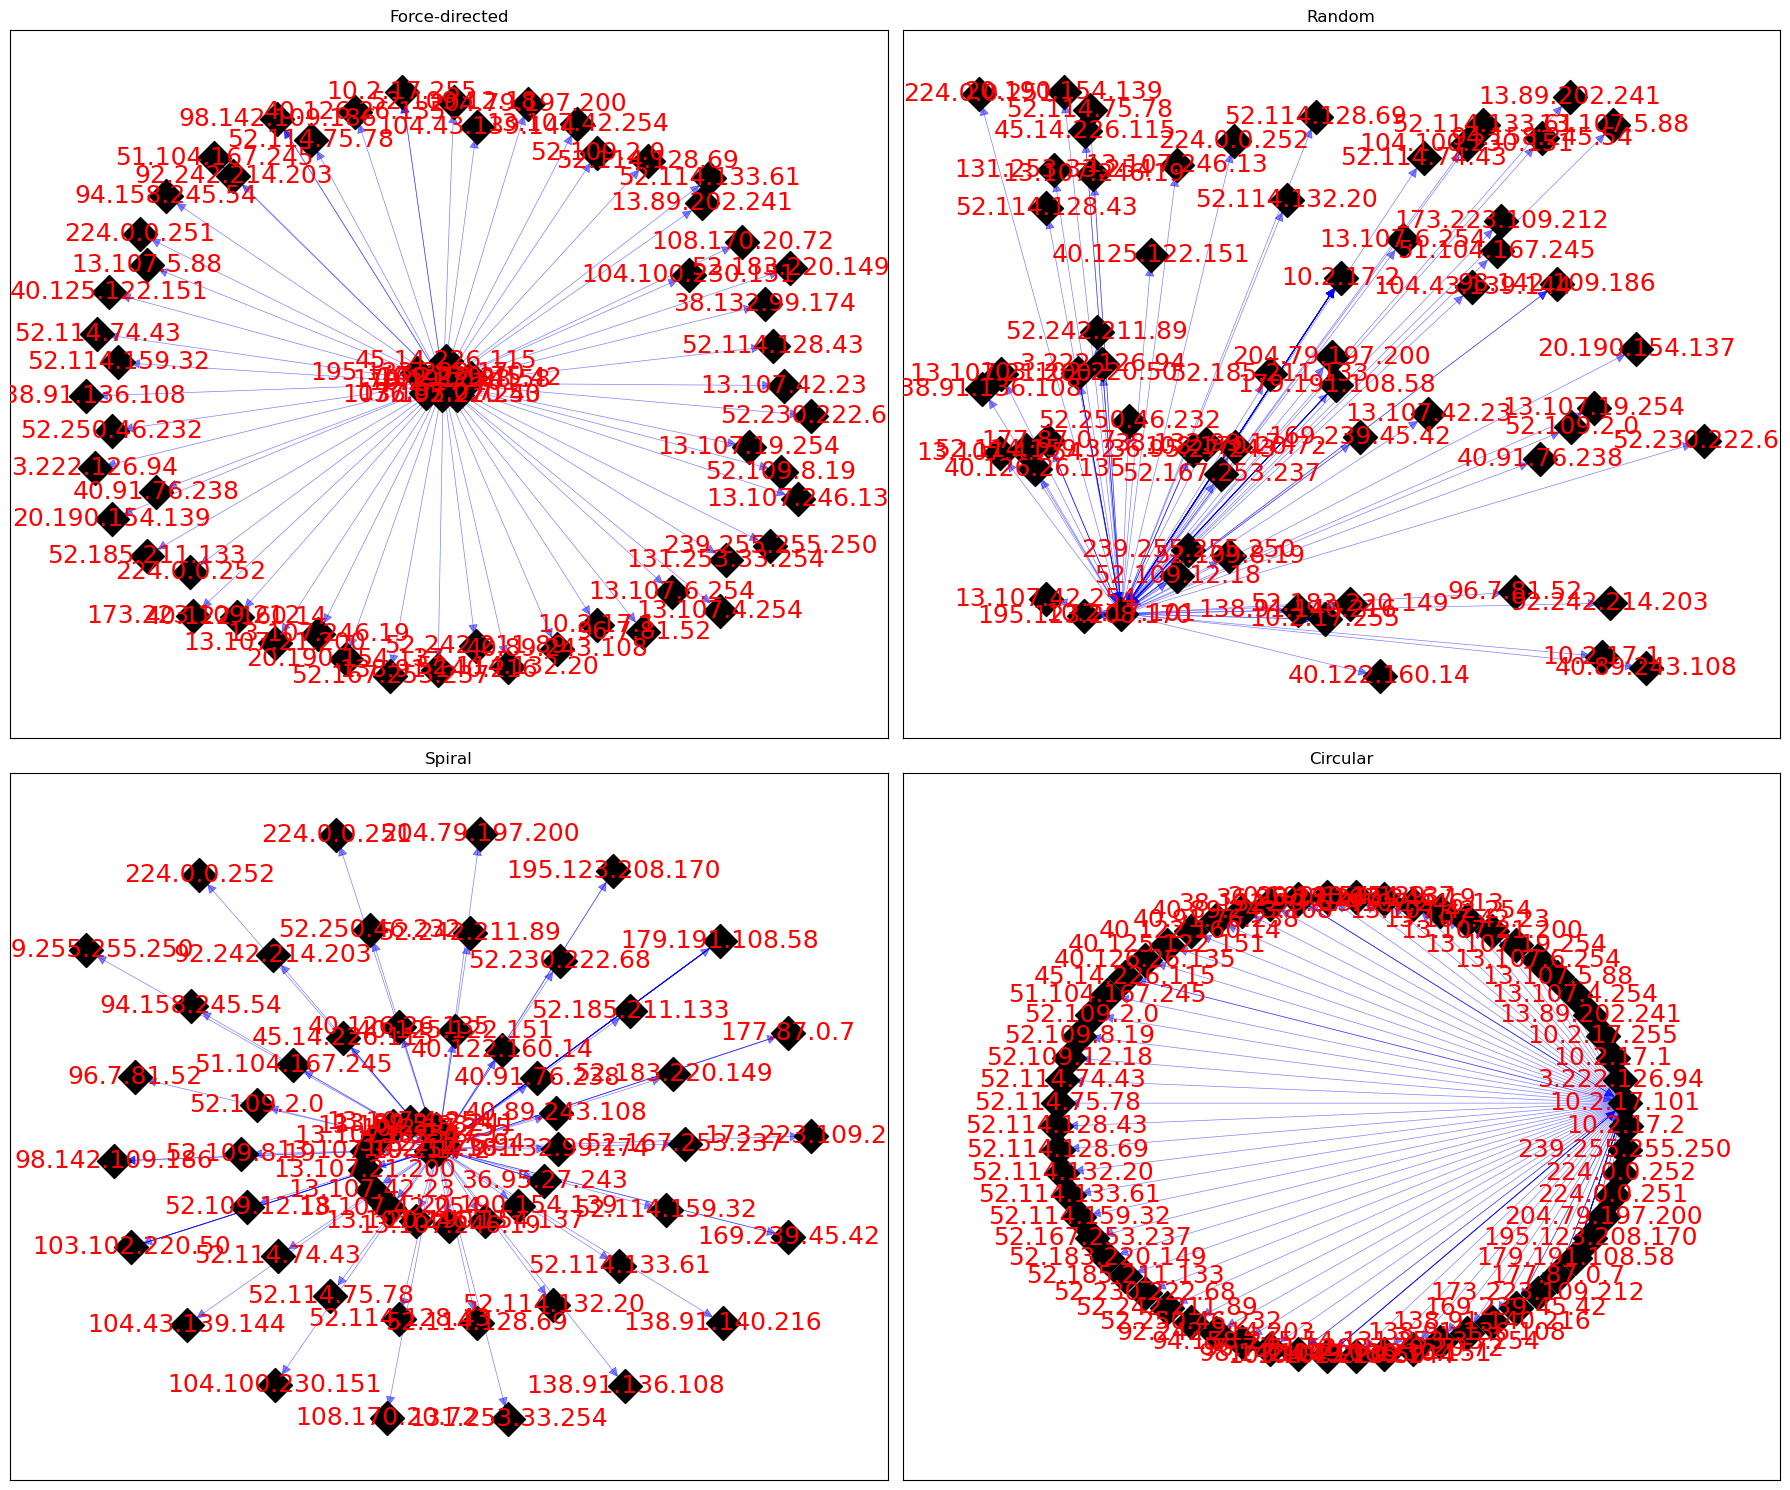

In [9]:
#Draw the graph:
layouts = (nx.spring_layout, nx.random_layout, nx.spiral_layout, nx.circular_layout)
titles = ("Force-directed", "Random", "Spiral", "Circular")

# Create the plots:
_, plot = plt.subplots(2, 2, figsize=fig_size)
# change plot arr to a single flat arr:
subplots = plot.reshape(1,4)[0]

# Draw a plot for each layout:
for plot, layout, title in zip(subplots, layouts, titles):
    pos = layout(Graph1)
    nx.draw_networkx_edges(Graph1, pos, ax=plot, width=0.5, style="solid", edge_color="blue", alpha=0.5, arrows=True, arrowsize=15, arrowstyle="-|>")
    nx.draw_networkx_nodes(Graph1, pos, ax=plot, node_color="black", node_shape="D")
    #draw labels:
    nx.draw_networkx_labels(Graph1, pos, ax=plot, font_color="red", font_size=18)
    plot.set_title(title)
plt.gca().margins(0.20, 0.20)
plt.tight_layout()
plt.show(block=False)

In [10]:
# Create lists for private, public, and reserved IP:
private_ips = []
global_ips = []
reserved_ips = []
for ip in Graph1.nodes:
    if (ipaddress.ip_address(ip).is_private):
        private_ips.append(ip)
    elif (ipaddress.ip_address(ip).is_global):
        global_ips.append(ip)
    elif (ipaddress.ip_address(ip).is_reserved):
        reserved_ips.append(ip)
        
# Create node label lists for each severity:
node_labels_sev0 = {}
node_labels_sev1 = {}
node_labels_sev2 = {}
node_labels_sev3 = {}
for (u,v) in Graph1.nodes(data=True):
    print(u,v)
    # print("\n")
    if (v["severity"] == 0 and v["conn_weight"] > 0.5):
        node_labels_sev0[u] = u
    elif (v["severity"] == 1):
        node_labels_sev1[u] = u
    elif (v["severity"] == 2):
        node_labels_sev2[u] = u
    elif (v["severity"] == 3):
        node_labels_sev3[u] = u
        
# Get alert_weight attribute from the graph for node sizing:
node_weights = nx.get_node_attributes(Graph1, "alert_weight")

10.2.17.2 {'alertcount': 1, 'severity': 2, 'alert_weight': 2.1, 'conn_weight': 0.1}
10.2.17.101 {'alertcount': 2, 'severity': 2, 'alert_weight': 4.1, 'conn_weight': 0.1}
3.222.126.94 {'alertcount': 1, 'severity': 2, 'alert_weight': 2.1, 'conn_weight': 0.1}
10.2.17.1 {'alertcount': 0, 'severity': 0, 'alert_weight': 0.1, 'conn_weight': 0.20309278350515464}
10.2.17.255 {'alertcount': 0, 'severity': 0, 'alert_weight': 0.1, 'conn_weight': 1.0278350515463917}
13.89.202.241 {'alertcount': 0, 'severity': 0, 'alert_weight': 0.1, 'conn_weight': 0.20309278350515464}
13.107.4.254 {'alertcount': 0, 'severity': 0, 'alert_weight': 0.1, 'conn_weight': 0.20309278350515464}
13.107.5.88 {'alertcount': 0, 'severity': 0, 'alert_weight': 0.1, 'conn_weight': 0.20309278350515464}
13.107.6.254 {'alertcount': 0, 'severity': 0, 'alert_weight': 0.1, 'conn_weight': 0.20309278350515464}
13.107.19.254 {'alertcount': 0, 'severity': 0, 'alert_weight': 0.1, 'conn_weight': 0.20309278350515464}
13.107.21.200 {'alertcount

In [11]:
# Create lists contain incoming and outcoming edges
# by using Suricata alert severity:
in_sev0 = []
out_sev0 = []
in_sev1 = []
out_sev1 = []
in_sev2 = []
out_sev2 = []
in_sev3 = []
out_sev3 = []
for (u,v,d) in Graph1.in_edges(data=True):
    if (d["severity"] == 0):
        in_sev0.append((u,v))
    elif (d["severity"] == 1):
        in_sev1.append((u,v))
    elif (d["severity"] == 2):
        in_sev2.append((u,v))
    elif (d["severity"] == 3):
        in_sev3.append((u,v))
for (u,v,d) in Graph1.in_edges(data=True):
    if (d["severity"] == 0):
        out_sev0.append((u,v))
    elif (d["severity"] == 1):
        out_sev1.append((u,v))
    elif (d["severity"] == 2):
        out_sev2.append((u,v))
    elif (d["severity"] == 3):
        out_sev3.append((u,v))    

# Get edge weights for in and out edges by alert severity:
edge_weights_conn_in = []
edge_weights_conn_out = []
edge_weights_alert_sev1_in = []
edge_weights_alert_sev1_out = []
edge_weights_alert_sev2_in = []
edge_weights_alert_sev2_out = []
edge_weights_alert_sev3_in = []
edge_weights_alert_sev3_out = []
for (u,v,d) in Graph1.in_edges(data=True):
    # print(d)
    if (d["severity"] == 0):
        edge_weights_conn_in.append(d["conn_weight"])
    elif (d["severity"] == 1):
        edge_weights_alert_sev1_in.append(d["alert_weight"])
    elif (d["severity"] == 2):
        edge_weights_alert_sev2_in.append(d["alert_weight"])
    elif (d["severity"] == 3):
        edge_weights_alert_sev3_in.append(d["alert_weight"])
for (u,v,d) in Graph1.out_edges(data=True):
    # print(d)
    if (d["severity"] == 0):
        edge_weights_conn_out.append(d["conn_weight"])
    elif (d["severity"] == 1):
        edge_weights_alert_sev1_out.append(d["alert_weight"])
    elif (d["severity"] == 2):
        edge_weights_alert_sev2_out.append(d["alert_weight"])
    elif (d["severity"] == 3):
        edge_weights_alert_sev3_out.append(d["alert_weight"])
        
# get edge labels and create dictionary of edges by Suricata alert severities:
edge_labels_sev1_in = {}
edge_labels_sev1_out = {}
edge_labels_sev2_in = {}
edge_labels_sev2_out = {}
edge_labels_sev3_in = {}
edge_labels_sev3_out = {}
for (u,v,d) in Graph1.in_edges(data=True):
    if (d["severity"] == 1):
        edge_labels_sev1_in[(u,v)] = d["alertcount"]
    elif (d["severity"] == 2):
        edge_labels_sev2_in[(u,v)] = d["alertcount"]
    elif (d["severity"] == 3):
        edge_labels_sev3_in[(u,v)] = d["alertcount"]
for (u,v,d) in Graph1.out_edges(data=True):
    if (d["severity"] == 1):
        edge_labels_sev1_out[(u,v)] = d["alertcount"]
    elif (d["severity"] == 2):
        edge_labels_sev2_out[(u,v)] = d["alertcount"]
    elif (d["severity"] == 3):
        edge_labels_sev3_out[(u,v)] = d["alertcount"]

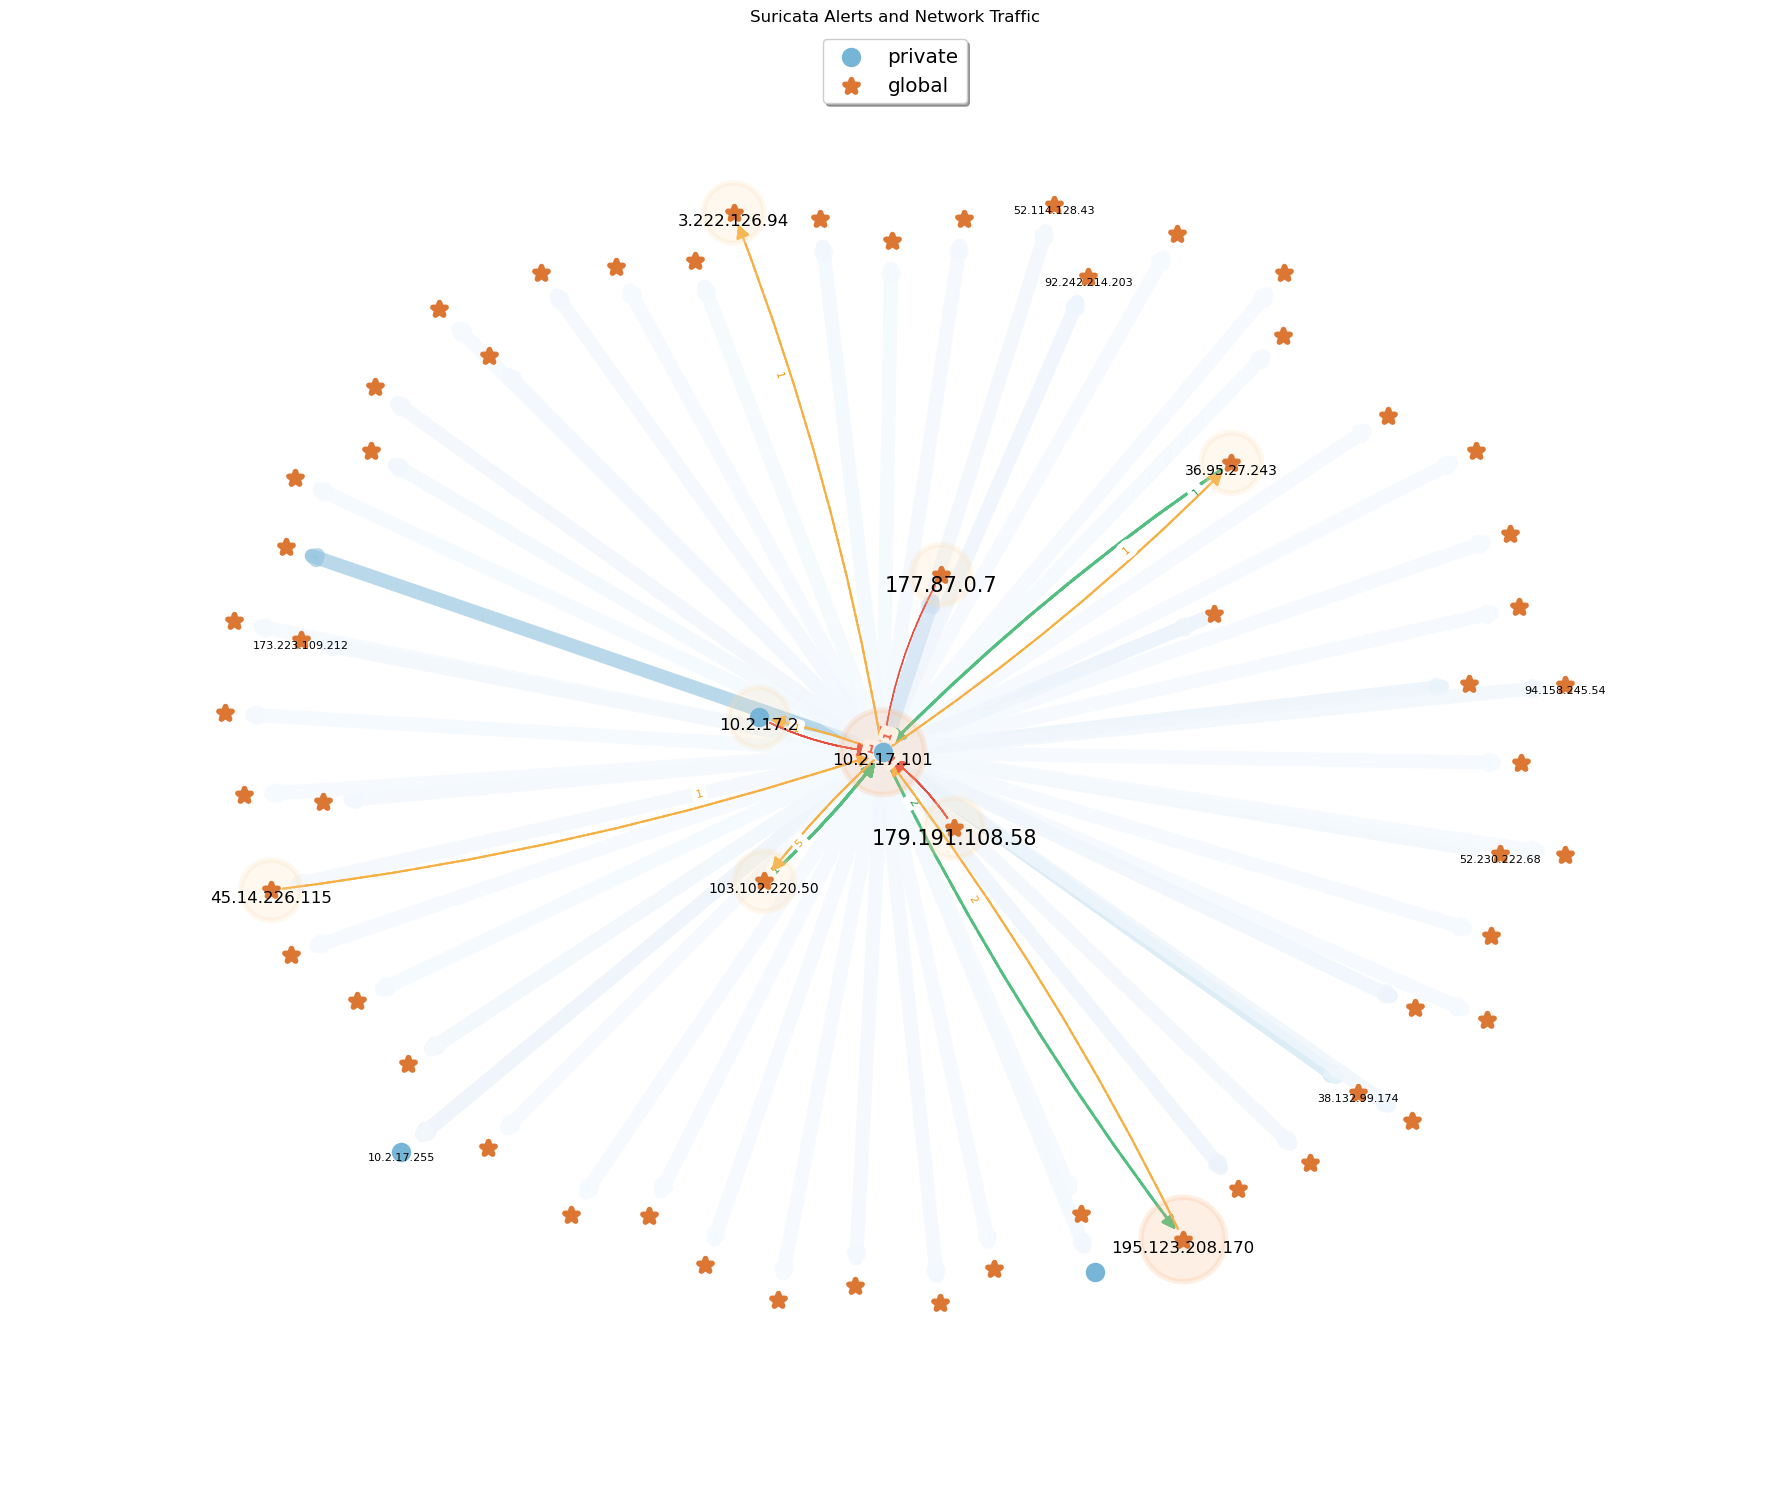

In [12]:
## Draw our graph
# Adjust the size of the figure to be plotted
plt.figure(figsize=fig_size)
# Set title
ax = plt.gca()
ax.set_title("Suricata Alerts and Network Traffic")
# Create the positioning for our graph using the Spring Layout.
# We're using "alertweight" for the layout weight, but you could also try "connweight", or even "severity" here
# k controls the distance between the nodes and varies between 0 and 1
# iterations is the number of times simulated annealing is run
# default k=0.1 and iterations=50
pos = nx.spring_layout(Graph1, scale=1.2, k=0.9, iterations=50, weight='alertweight')

# Draw Zeek connection edges (severity 0), color edges on a blue scale by the connection weight (based on the count of unique
# connections) for incoming and outgoing connections
nx.draw_networkx_edges(Graph1, pos, width=10, style='solid', edgelist=in_sev0, edge_color=edge_weights_conn_in,edge_cmap=plt.cm.Blues,edge_vmin=0.1,edge_vmax=10.1, alpha=0.6, arrows=True, min_source_margin=0.2,min_target_margin=0.2)
nx.draw_networkx_edges(Graph1, pos, width=10, style='solid', edgelist=out_sev0,edge_color=edge_weights_conn_out,edge_cmap=plt.cm.Blues,edge_vmin=0.1,edge_vmax=10.1, alpha=0.6, arrows=True, min_source_margin=0.2,min_target_margin=0.2)
# # Draw all nodes based on our node_weights (based on alertweight). This will color nodes on a cool/warm scale,
# # and also draw the node size based on the weight. We draw the nodes transparently, so that we can draw the node type on top
nx.draw_networkx_nodes(Graph1, 
                       pos, 
                       nodelist=node_weights.keys(),
                       node_color=list(node_weights.values()),
                       cmap=plt.cm.OrRd,
                       vmin=0.1,
                       vmax=10.1,
                       node_shape='o',
                       linewidths=4,
                       alpha=0.2,
                       node_size=[v * 900 for v in node_weights.values()])


# # Draw the type of node on top of each node, for global, private and reserved IP's
nx.draw_networkx_nodes(Graph1, 
                       pos, 
                       nodelist=private_ips,
                       node_color='#77B5D7', 
                       node_shape='o',
                       linewidths=4,
                       alpha=1,
                       label='private',
                       node_size=100)
nx.draw_networkx_nodes(Graph1, 
                       pos, 
                       nodelist=global_ips, 
                       node_color='#DC7633', 
                       node_shape='*',  
                       linewidths=4,
                       alpha=1,
                       label='global',
                       node_size=100)

nx.draw_networkx_nodes(Graph1, 
                       pos, 
                       nodelist=reserved_ips, 
                       node_color='#C0392B', 
                       node_shape='P',  
                       linewidths=4,
                       alpha=1,
                       label='reserved',
                       node_size=100)

# # Draw the corresponding labels for each node
# # For Severity 1
nx.draw_networkx_labels(Graph1, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev1,
                        font_size=10)
# # For Severity 2
nx.draw_networkx_labels(Graph1, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev2,
                        font_size=12)
# # For Severity 3
nx.draw_networkx_labels(Graph1, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev3,
                        font_size=15)
# # For connections with a connection weight of over 0.5
nx.draw_networkx_labels(Graph1, 
                        pos,
                        font_color='black',
                        verticalalignment='top',
                        labels=node_labels_sev0,
                        font_size=8)

# # Draw our edges and edge labels for each severity
# # Red = 3
# # Yellow = 2
# # Green =1
# For the edge labels we show the count of Suricata alerts
nx.draw_networkx_edges(Graph1, 
                       pos, 
                       edgelist=in_sev1, 
                       width=2, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev1',
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(Graph1,
                             pos,
                             edge_labels=edge_labels_sev1_in,
                             label_pos=0.9,
                             font_color='#229954',
                             font_size=8)
nx.draw_networkx_edges(Graph1, 
                       pos, 
                       edgelist=out_sev1, 
                       width=2, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#52BE80',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(Graph1, 
                             pos, 
                             edge_labels=edge_labels_sev1_out, 
                             label_pos=0.9, 
                             font_color='#229954', 
                             font_size=8)

nx.draw_networkx_edges(Graph1, 
                       pos, 
                       edgelist=in_sev2, 
                       width=1.5, 
                       style='solid', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       label='sev2',
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(Graph1, 
                             pos, 
                             edge_labels=edge_labels_sev2_in, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)
nx.draw_networkx_edges(Graph1, 
                       pos, 
                       edgelist=out_sev2, 
                       width=1.5, 
                       style='dashed', 
                       connectionstyle='arc3,rad=0.05',
                       edge_color='#F5B041',
                       alpha=1, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=3.0,
                       min_target_margin=3.0)

nx.draw_networkx_edge_labels(Graph1, 
                             pos, 
                             edge_labels=edge_labels_sev2_out, 
                             label_pos=0.3, 
                             font_color='#F39C12', 
                             font_size=8)

nx.draw_networkx_edges(Graph1, 
                       pos,
                       edgelist=in_sev3, 
                       width=1, 
                       style='solid',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       label='sev3',
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(Graph1, 
                             pos, 
                             edge_labels=edge_labels_sev3_in, 
                             label_pos=0.1, 
                             font_color='#E74C3C', 
                             font_weight="bold", 
                             font_size=8)

nx.draw_networkx_edges(Graph1, 
                       pos,
                       edgelist=out_sev3, 
                       width=1, 
                       style='dotted',
                       connectionstyle='arc3,rad=0.1',
                       edge_color='#E74C3C',
                       alpha=0.8, 
                       arrows=True,
                       arrowsize=20,
                       min_source_margin=5.0,
                       min_target_margin=5.0)

nx.draw_networkx_edge_labels(Graph1, 
                             pos, 
                             edge_labels=edge_labels_sev3_out, 
                             label_pos=0.1, 
                             font_color='#E74C3C',
                             font_weight="bold", 
                             font_size=8)

# Draw without box lines
plt.box(on=None)
# Draw legend
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
# Set margins
plt.gca().margins(0.1, 0.1)
# Set tight layout
plt.tight_layout()
plt.show()